# Dataset 1 - Regression

## Import Libraries 

In [1]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn
import warnings
warnings.filterwarnings('ignore')

## Parameters

General Parameters 

1. Number of Samples 

Discriminator Parameters

1. Size : number of hidden nodes 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [2]:
n_features = 10
sample_size = 100
#Discriminator Parameters 
hidden_nodes = 25 
#ABC Generator Parameters
mean = 1 
variance = 0.001

## Dataset

Generate a random regression problem

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$

In [3]:
X,Y = regressionDataset.regression_data(sample_size,n_features)

         X1        X2        X3        X4        X5        X6        X7  \
0  0.434707 -0.917121 -0.626925  0.215444  0.852555 -0.121587  0.091714   
1  0.373515  1.105485 -0.016820  1.264758  0.395600  0.129483 -2.760473   
2  0.438613  1.168760  0.678766  0.563138 -0.845732  0.668833 -1.342623   
3 -0.313215 -0.025171 -0.653642  0.632126  2.627035  1.230031  1.317050   
4 -0.523672 -0.432872 -0.623221  0.084084 -1.178197  1.639826 -0.156760   

         X8        X9       X10           Y  
0  2.465981  0.930050 -0.613717   95.251652  
1 -1.064269 -0.864088 -2.621065  -49.747172  
2 -1.493481  1.341433  0.011696   95.589563  
3 -0.525310 -1.953364  1.482266  269.311266  
4 -1.127700 -1.837001 -0.231477 -123.124987  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.404e+07
Date:                Thu, 07 Oct 2021   Prob (F-statistic):          1.26e-281
Time:                        18:57:05   Log-Likelihood:                 598.58
No. Observations:                 100   AIC:                            -1175.
Df Residuals:                      89   BIC:                            -1146.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.592e-17   6.45e-05  -1.02e-12      1.0

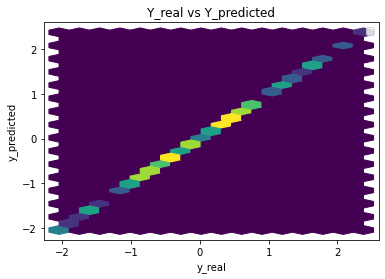

Performance Metrics
Mean Squared Error: 3.7014079805294754e-07
Mean Absolute Error: 0.00045660103901463224
Manhattan distance: 0.045660103901463224
Euclidean distance: 0.006083919773081722


In [4]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

# Generator and Discriminator Networks 

**GAN Generator**

In [5]:
class Generator(nn.Module):

  def __init__(self,n_input):
    super().__init__()
    self.output = nn.Linear(n_input,1)

  def forward(self, x):
    x = self.output(x)
    return x 

**GAN Discriminator**

In [6]:
class Discriminator(nn.Module):

  def __init__(self,n_input,n_hidden):

    super().__init__()
    self.hidden = nn.Linear(n_input,n_hidden)
    self.output = nn.Linear(n_hidden,1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.hidden(x)
    x = self.relu(x)
    x = self.output(x)
    return x 

**ABC Generator**

The ABC generator is defined as follows:

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 

$\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else

$\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from stats model

Parameters : $\mu$ and $\sigma^{*}$

$\sigma^{*}$ takes the values 0.01,0.1 and 1

In [7]:
def ABC_pre_generator(x_batch,coeff,variance,mean,device):

  coeff_len = len(coeff)

  if mean == 0:
    weights = np.random.normal(0,variance,size=(coeff_len,1))
    weights = torch.from_numpy(weights).reshape(coeff_len,1)
  else:
    weights = []
    for i in range(coeff_len):
      weights.append(np.random.normal(coeff[i],variance))
    weights = torch.tensor(weights).reshape(coeff_len,1)
    
  y_abc =  torch.matmul(x_batch,weights.float())
  gen_input = torch.cat((x_batch,y_abc),dim = 1).to(device)
  return gen_input 

# GAN Model

In [8]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
generator = Generator(n_features+2)
discriminator = Discriminator(n_features+2,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [10]:
print(generator)
print(discriminator)

Generator(
  (output): Linear(in_features=12, out_features=1, bias=True)
)
Discriminator(
  (hidden): Linear(in_features=12, out_features=25, bias=True)
  (output): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
)


In [11]:
n_epochs = 5000
batch_size = sample_size//2

In [12]:
# Parameters
sample_size = 100
mean = 0
std = 1


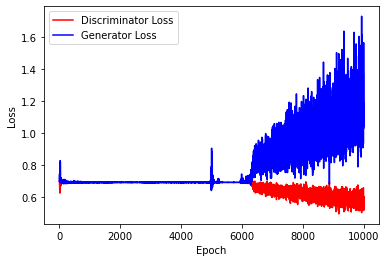

In [13]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

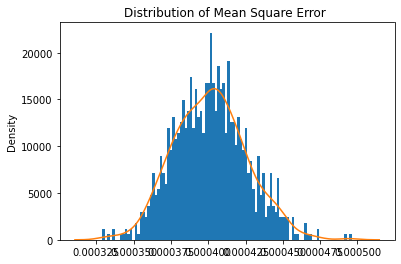

Mean Square Error: 0.00040156763600383887


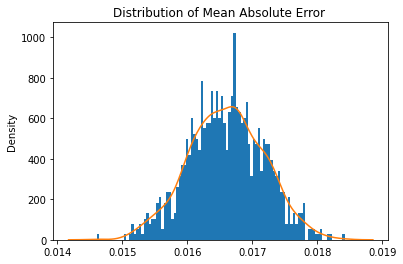

Mean Absolute Error: 0.016598818658813835


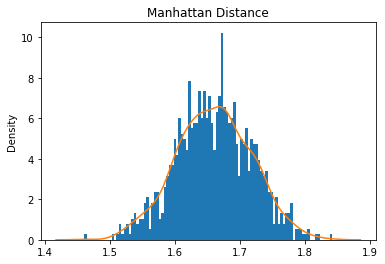

Mean Manhattan Distance: 1.6598818658813834


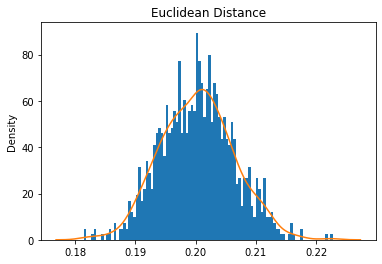

Mean Euclidean Distance: 1.6598818658813834


In [14]:
train_test.test_generator(generator,real_dataset,device)

# ABC GAN Model

#### Training the network

In [15]:
gen = Generator(n_features+2)
disc = Discriminator(n_features+2,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [16]:
n_epoch_abc = 2000
batch_size = sample_size//2

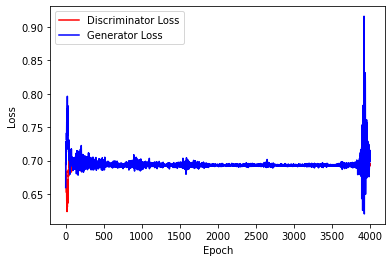

In [17]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epoch_abc,criterion,coeff,mean,variance,device)

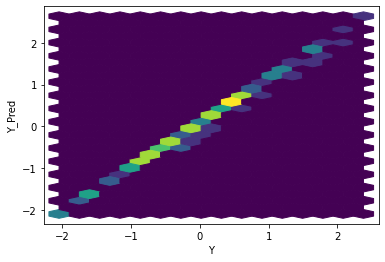

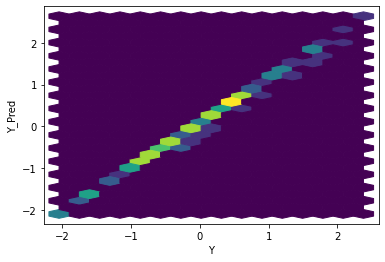

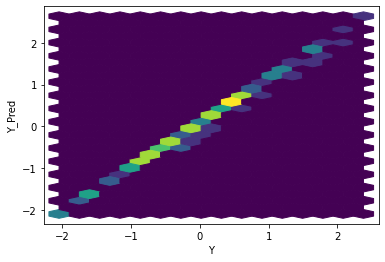

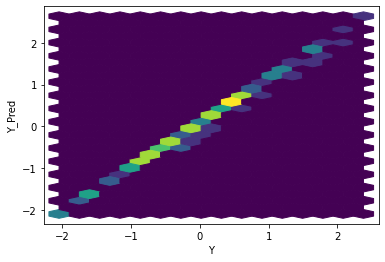

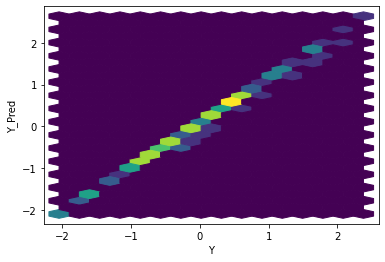

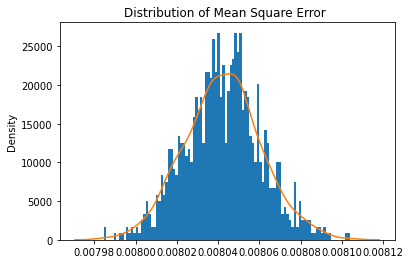

Mean Square Error: 0.008042345046360767


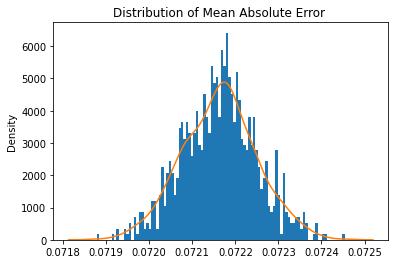

Mean Absolute Error: 0.07216294618889689


Mean Manhattan Distance: 7.216294618889689


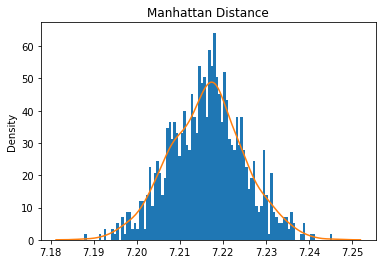

Mean Euclidean Distance: 0.8967906268159557


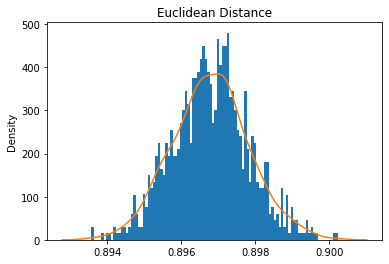

In [18]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

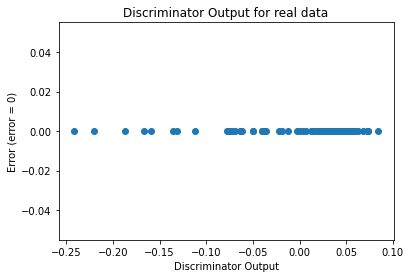

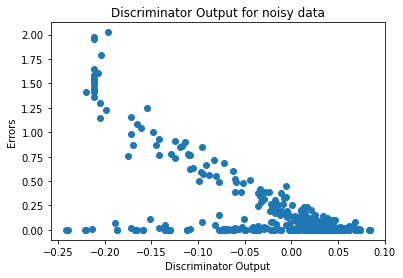

In [19]:
sanityChecks.discProbVsError(real_dataset,disc,device)

## Visualization of trained GAN generator 

In [20]:
for name, param in gen.named_parameters():
    print(name,param)

output.weight Parameter containing:
tensor([[-0.1319,  0.0175,  0.0681,  0.3999,  0.4217,  0.5107,  0.4318,  0.0174,
          0.1862,  0.2438,  0.4075,  0.1090]], requires_grad=True)
output.bias Parameter containing:
tensor([0.1766], requires_grad=True)
